In [2]:
import random
from collections import Counter

# Define a simple circuit: takes n bits, outputs m bits
def circuit_identity(r):
    # Just return the first 2 bits
    return (r[0], r[1])

def circuit_xor(r):
    # Output XOR of first two bits and the third bit
    return (r[0] ^ r[1], r[2])

def sample_bits(n):
    return [random.randint(0,1) for _ in range(n)]


In [3]:
def sample_distribution(circuit, n, samples=1000):
    counts = Counter()
    for _ in range(samples):
        r = sample_bits(n)
        out = circuit(r)
        counts[out] += 1
    # Normalize to probabilities
    return {k: v/samples for k,v in counts.items()}

# Example: compare two circuits
dist_id = sample_distribution(circuit_identity, n=3)
dist_xor = sample_distribution(circuit_xor, n=3)

print("Identity circuit distribution:", dist_id)
print("XOR circuit distribution:", dist_xor)


Identity circuit distribution: {(0, 1): 0.262, (0, 0): 0.247, (1, 1): 0.244, (1, 0): 0.247}
XOR circuit distribution: {(0, 1): 0.241, (0, 0): 0.266, (1, 0): 0.255, (1, 1): 0.238}


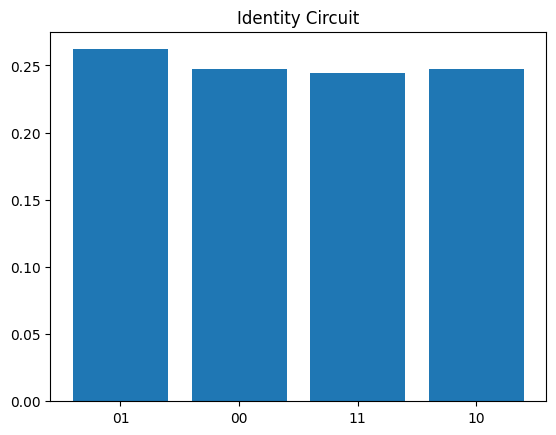

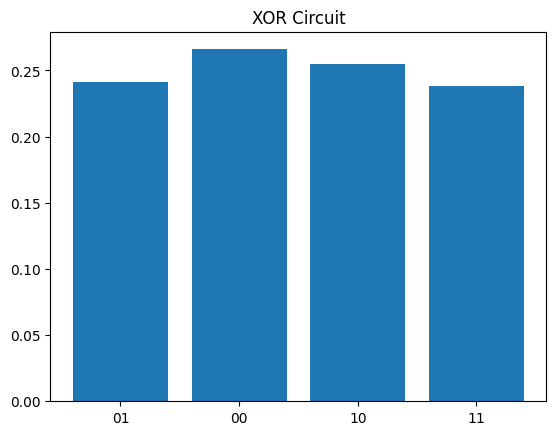

In [4]:
import matplotlib.pyplot as plt

def plot_distribution(dist, title):
    keys = [''.join(map(str,k)) for k in dist.keys()]
    values = list(dist.values())
    plt.bar(keys, values)
    plt.title(title)
    plt.show()

plot_distribution(dist_id, "Identity Circuit")
plot_distribution(dist_xor, "XOR Circuit")


**Total Variation Distance (black-box):**  
$$
\mathrm{TV}(P,Q) \;=\; \tfrac{1}{2}\sum_x \big|P(x)-Q(x)\big| \;\in\;[0,1]
$$  
0 means identical; 1 means completely disjoint support.

In [5]:
# Total Variation (statistical) distance between two finite distributions
def tv_distance(P, Q):
    keys = set(P.keys()) | set(Q.keys())
    return 0.5 * sum(abs(P.get(k, 0.0) - Q.get(k, 0.0)) for k in keys)

# 1) TV between the two circuits
tv_id_xor = tv_distance(dist_id, dist_xor)
print(f"TV(dist_id, dist_xor) ≈ {tv_id_xor:.3f}")

# (Optional) Compare each to the uniform distribution over 2-bit outputs
uniform_2bit = { (0,0):0.25, (0,1):0.25, (1,0):0.25, (1,1):0.25 }
tv_id_unif = tv_distance(dist_id, uniform_2bit)
tv_xor_unif = tv_distance(dist_xor, uniform_2bit)
print(f"TV(dist_id, uniform) ≈ {tv_id_unif:.3f}")
print(f"TV(dist_xor, uniform) ≈ {tv_xor_unif:.3f}")


TV(dist_id, dist_xor) ≈ 0.027
TV(dist_id, uniform) ≈ 0.012
TV(dist_xor, uniform) ≈ 0.021



## The Distinguishing Game

1. **Two Distributions:**  
   - Distribution **X_0** (e.g., outputs 1 with probability 0.7)  
   - Distribution **X_1** (e.g., outputs 1 with probability 0.3)

2. **The Game:**  
   1. b $\gets \{0,1\}$ uniformly at random
   2. sample $k$ times from $X_b$
   3. goal is to guess if $X_b$ is $X_0$ or $X_1$ based on the samples
   - $X_0$ outputs 1 with more probability, guess $X_0$ if distribution of samples contains more 1's, else guess $X_1$

3. **Output Accuracy**  
- one sample: $0.5 + \text{TV}(X_0,X_1)$
- For $X_0=0.7, X_1=0.3$
- $\text{TV} = \tfrac{1}{2}\sum_x \big|0.7-0.3\big|$ = 0.2

4. **Accuracy with more samples:**  
   - With **k = 10 samples**, you count how many 1’s you saw.  
   - If count $\geq$ threshold → guess $X_0$, else $X_1$
   - As **k grows**, the two distributions (Binomial(k,0.7) vs Binomial(k,0.3)) separate more $\implies$  
     $TV(X_0^k,X_1^k)$ grows accuracy approaches 1.

Realized biases: p0=0.55000, p1=0.45000


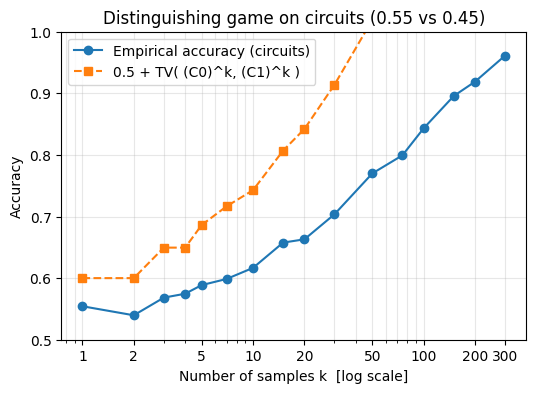

In [10]:
# ---------- 1) Circuits: deterministic "biased-bit" from uniform n-bit input ----------
def biased_bit_circuit(n, target_p):
    T = int(round(target_p * (2**n)))              # threshold in [0, 2^n]
    def C(r_bits):                                 # r_bits: list of n bits
        U = 0
        for b in r_bits:
            U = (U << 1) | (b & 1)
        return 1 if U < T else 0
    C.n = n
    C.p = T / (2**n)                               # realized bias (exact)
    return C

def sample_bit(C):
    r = [random.randint(0,1) for _ in range(C.n)]  # uniform input bits
    return C(r)

# ---------- 2) Distinguishing game with k samples (optimal count-based rule) ----------
def optimal_threshold(k, p0, p1):
    # LLR rule reduces to a threshold on #ones: choose C0 if s >= t
    a = math.log(p0/p1)
    b = math.log((1-p0)/(1-p1))
    return math.ceil(k * (-b) / (a - b))

def empirical_accuracy(C0, C1, k, trials=3000):
    p0, p1 = C0.p, C1.p
    t = optimal_threshold(k, p0, p1)
    correct = 0
    for _ in range(trials):
        src0 = (random.random() < 0.5)           # pick which circuit generated
        s = sum(sample_bit(C0 if src0 else C1) for _ in range(k))
        guess0 = (s >= t)                        # threshold test
        correct += (guess0 == src0)
    return correct / trials

# ---------- 3) Theoretical optimum: 0.5 + TV( (Bern p0)^k, (Bern p1)^k ) ----------
def binom_pmf(k, s, p):
    return math.comb(k, s) * (p**s) * ((1-p)**(k-s))

def tv_product_bernoulli(k, p0, p1):
    return 0.5 * sum(abs(binom_pmf(k, s, p0) - binom_pmf(k, s, p1)) for s in range(k+1))

# ---------- 4) Make two close-bias circuits so growth is smooth ----------
n = 16                        # input bits per circuit (small & exact)
C0 = biased_bit_circuit(n, 0.55)
C1 = biased_bit_circuit(n, 0.45)
print(f"Realized biases: p0={C0.p:.5f}, p1={C1.p:.5f}")

# k on a log-like grid (no numpy)
Ks = [1,2,3,4,5,7,10,15,20,30,50,75,100,150,200,300]
emp, opt = [], []
for k in Ks:
    emp.append(empirical_accuracy(C0, C1, k))
    opt.append(0.5 + tv_product_bernoulli(k, C0.p, C1.p))

# ---------- 5) Plot ----------
plt.figure(figsize=(6,4))
plt.plot(Ks, emp, 'o-', label='Empirical accuracy (circuits)')
plt.plot(Ks, opt, 's--', label='0.5 + TV( (C0)^k, (C1)^k )')
plt.xscale('log')
plt.xticks([1,2,5,10,20,50,100,200,300], labels=[1,2,5,10,20,50,100,200,300])
plt.ylim(0.5, 1.0)
plt.xlabel('Number of samples k  [log scale]')
plt.ylabel('Accuracy')
plt.title('Distinguishing game on circuits (0.55 vs 0.45)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.show()
